In [93]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import Transformer
import torch.nn.functional as F
from torch import Tensor
from torch import nn
import torch.optim as optim
import warnings
import random
import torch
import math
#import yaml
import json
import matplotlib.pyplot as plt
import os
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

# warnings.filterwarnings("ignore")

## Parameters

In [94]:
embedding_num = 30
embedding_dim = 256
num_layers = 8
num_heads = 8
ff_dim = 1024
dropout = 0.1
pad_idx = 0
sos_idx = 28

# Functions

### Bleu

In [95]:
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)


### Index2Char

In [96]:
class Index2Char():
    def __init__(self, char_to_index):
        # 创建从索引到字符的反向映射
        self.index_to_char = {index: char for char, index in char_to_index.items()}


    def __call__(self, indices:list, without_token=True):
        if type(indices) == Tensor:
            indices = indices.tolist()
        result =   ''.join(self.index_to_char.get(index, '') for index in indices)
        if without_token:
            result = result.split('<EOS>')[0]
            result = result.replace('<SOS>', '').replace('<EOS>', '').replace('[pad]', '')
        return result


### SpellCorrectionDataset

In [97]:



class SpellCorrectionDataset(Dataset):
    def __init__(self, root, split='train', padding=0):
        super(SpellCorrectionDataset, self).__init__()

        self.char_to_index = self.build_char_to_index()
        self.padding = padding
        self.data = self.load_data(root, split)

    def build_char_to_index(self):
        # 创建字符到索引的映射
        characters = 'abcdefghijklmnopqrstuvwxyz'
        char_to_index = {char: i + 1 for i, char in enumerate(characters)}
        char_to_index['<UNK>'] = len(char_to_index) + 1  # 未知字符
        char_to_index['<SOS>'] = len(char_to_index) + 1  # 序列开始
        char_to_index['<EOS>'] = len(char_to_index) + 1  # 序列结束
        return char_to_index

    def load_data(self, root, split):
        # 加载 JSON 数据
        filename = f'{root}/{split}.json'
        with open(filename, 'r') as file:
            data = json.load(file)
        flattened_data = []
        for item in data:
            for inp in item["input"]:
                flattened_data.append((inp, item["target"]))
        return flattened_data

    def tokenize(self, text):
        # 将文本转换为索引
         return [self.char_to_index['<SOS>']] + \
               [self.char_to_index.get(char, self.char_to_index['<UNK>']) for char in text] + \
               [self.char_to_index['<EOS>']]
    def pad_sequence(self, sequence):
        # 填充序列至固定长度
        padded_sequence = sequence[:self.padding]
        padded_sequence += [0] * (self.padding - len(padded_sequence))
        return padded_sequence
    def get_char_to_index(self):
        # 返回 char_to_index 映射
        return self.char_to_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        try:
            item = self.data[index]
            # 單詞分割
            input_ids = self.tokenize(item[0])
            target_ids = self.tokenize(item[1])
            input_ids = self.pad_sequence(input_ids)
            target_ids = self.pad_sequence(target_ids)


        except KeyError as e:
            print(f"KeyError accessing data: {e}")
            print(f"Data at index {index} is: {self.data[index]}")
            raise e
        except Exception as e:
            print(f"An error occurred at index {index}: {e}")
            raise e
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(target_ids, dtype=torch.long)

### metrics

In [98]:
def metrics(pred:list, target:list) -> float:
    """
    pred: list of strings
    target: list of strings

    return: accuracy(%)
    """
    if len(pred) != len(target):
        raise ValueError('length of pred and target must be the same')
    correct = 0
    for i in range(len(pred)):
        if pred[i] == target[i]:
            correct += 1
    return correct / len(pred) * 100

### printplot

In [99]:
def printplot(setname,losses, accuarcys, bleus):
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 3, 1)
  plt.plot(losses,color='orange')
  plt.xlabel('Epoch')
  plt.ylabel(f'Average {setname} Loss')
  plt.title(f'{setname} Loss Per Epoch')

  plt.subplot(1, 3, 3)
  plt.plot(bleus,color='orange')
  plt.xlabel('Epoch')
  plt.ylabel(f'Average {setname} BLEU Score')
  plt.title(f'{setname} BLEU Score Per Epoch')

  plt.subplot(1, 3, 2)
  plt.plot(accuarcys,color='orange')
  plt.xlabel('Epoch')
  plt.ylabel(f'Average {setname} Accuracy %')
  plt.title(f'{setname} Accuracy(%) Per Epoch')

  plt.show()

In [100]:



class SpellCorrectionDataset(Dataset):
    def __init__(self, root, split='train', padding=0):
        super(SpellCorrectionDataset, self).__init__()

        self.char_to_index = self.build_char_to_index()
        self.padding = padding
        self.data = self.load_data(root, split)

    def build_char_to_index(self):
        # 创建字符到索引的映射
        characters = 'abcdefghijklmnopqrstuvwxyz'
        char_to_index = {char: i + 1 for i, char in enumerate(characters)}
        char_to_index['<UNK>'] = len(char_to_index) + 1  # 未知字符
        char_to_index['<SOS>'] = len(char_to_index) + 1  # 序列开始
        char_to_index['<EOS>'] = len(char_to_index) + 1  # 序列结束
        return char_to_index

    def load_data(self, root, split):
        # 加载 JSON 数据
        filename = f'{root}/{split}.json'
        with open(filename, 'r') as file:
            data = json.load(file)
        flattened_data = []
        for item in data:
            for inp in item["input"]:
                flattened_data.append((inp, item["target"]))
        return flattened_data

    def tokenize(self, text):
        # 将文本转换为索引
         return [self.char_to_index['<SOS>']] + \
               [self.char_to_index.get(char, self.char_to_index['<UNK>']) for char in text] + \
               [self.char_to_index['<EOS>']]
    def pad_sequence(self, sequence):
        # 填充序列至固定长度
        padded_sequence = sequence[:self.padding]
        padded_sequence += [0] * (self.padding - len(padded_sequence))
        return padded_sequence

    def get_char_to_index(self):
        # 返回已创建的 char_to_index 字典
        return self.char_to_index
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        try:
            item = self.data[index]
            # 單詞分割
            input_ids = self.tokenize(item[0])
            target_ids = self.tokenize(item[1])
            input_ids = self.pad_sequence(input_ids)
            target_ids = self.pad_sequence(target_ids)


        except KeyError as e:
            print(f"KeyError accessing data: {e}")
            print(f"Data at index {index} is: {self.data[index]}")
            raise e
        except Exception as e:
            print(f"An error occurred at index {index}: {e}")
            raise e
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(target_ids, dtype=torch.long)

In [101]:
class Index2Char():
    def __init__(self, char_to_index):
        # 创建从索引到字符的反向映射
        self.index_to_char = {index: char for char, index in char_to_index.items()}


    def __call__(self, indices:list, without_token=True):
        if type(indices) == Tensor:
            indices = indices.tolist()
        result =   ''.join(self.index_to_char.get(index, '') for index in indices)
        if without_token:
            result = result.split('<EOS>')[0]
            result = result.replace('<SOS>', '').replace('<EOS>', '').replace('[pad]', '')
        return result

In [102]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000, batch_first=True):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        self.batch_first = batch_first

    def forward(self, x: Tensor) -> Tensor:
        if self.batch_first:
            x = x.transpose(0, 1)
            x = x + self.pe[:x.size(0)]
            return self.dropout(x.transpose(0, 1))
        else:
            x = x + self.pe[:x.size(0)]
            return self.dropout(x)

# Model &Encoder & Decoder

In [103]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer


### PositionalEncoding

### Model

In [104]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.pos_encoder = PositionalEncoding(d_model, dropout, batch_first=True)
        # Embedding Layer
        self.en_embedding = nn.Embedding(vocab_size, d_model)
        self.de_embedding = nn.Embedding(vocab_size, d_model)

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,batch_first=True, norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,batch_first=True, norm_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Output Linear Layer
        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt,src_pad_mask, tgt_mask, tgt_pad_mask):
        # Source and Target Embeddings
        src = self.en_embedding(src).to(device)
        src = self.pos_encoder(src)
        #print("src",src)
        tgt = self.de_embedding(tgt).to(device)
        tgt = self.pos_encoder(tgt)

        # Encoder Output
        encoder_output = self.transformer_encoder(src,src_key_padding_mask=src_pad_mask,)
        # Decoder Output
        decoder_output = self.transformer_decoder(
            tgt,
            memory=encoder_output,
            tgt_key_padding_mask=tgt_pad_mask,
           memory_key_padding_mask=src_pad_mask,
            tgt_mask=tgt_mask
        )
        # Final Output
        output = self.out(decoder_output)
        return output


### Mask

In [105]:
def gen_padding_mask(src, pad_idx):
    # detect where the padding value is
    pad_mask = (src == pad_idx)  # [seq_len, batch_size]
    return pad_mask.bool()

def gen_mask(seq,device):
    sz = seq.size(1)
    mask = torch.triu(torch.ones(sz, sz),diagonal=1).bool()

    return mask.to(device)

def get_index(pred, dim=2):
    return pred.clone().argmax(dim=dim)

def random_change_idx(data: torch.Tensor, prob: float = 0.2):
    # randomly change the index of the input data
    sample = data.clone()
    for i in range(data.size(0)):
        if torch.rand(1).item() < prob:
            random_idx = torch.randint(len(data), (1,))
            sample[i] = data[random_idx]
    return sample

def random_masked(data: torch.Tensor, prob: float = 0.2, mask_idx: int = 3):
    # randomly mask the input data
    sample = data.clone()
    for i in range(data.size(0)):
        if torch.rand(1).item() < prob:
            sample[i] = mask_idx
    return sample

# Pretrained encoder with random mask

In [106]:
# You can try to pretrain the Encoder here!

# Train our spelling correction transformer

In [107]:
from tqdm import tqdm

trainset = SpellCorrectionDataset('./data/', split='train', padding=22)
char_to_index = trainset.build_char_to_index()
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = SpellCorrectionDataset('./data/', split='test', padding=22)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
valset = SpellCorrectionDataset('./data/', split='new_test', padding=22)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ce_loss = nn.CrossEntropyLoss(ignore_index = pad_idx)

### Validations

In [108]:
def validation(setname,dataloader, model, device, logout=True):
    pred_str_list = []
    tgt_str_list = []
    input_str_list = []
    losses = []
    bleu_scores = []
    accuracy_scores = []
    total_loss = 0
    total_bleu_score = 0
    total_accuracy = 0
    total_batches = 0
    i2c = Index2Char(char_to_index)

    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = torch.full_like(tgt, pad_idx)
        tgt_input[:, 0] = sos_idx

        for i in range(tgt.shape[1]-1):
            src_pad_mask = gen_padding_mask(src, pad_idx).to(device)
            tgt_pad_mask = gen_padding_mask(tgt_input[:, :i+1], pad_idx).to(device)
            tgt_mask = gen_mask(tgt_input[:, :i+1], device)
            pred = model(src, tgt_input[:, :i+1], src_pad_mask, tgt_mask, tgt_pad_mask)

            next_token = pred[:, -1].argmax(dim=-1)
            if i < tgt.shape[1] - 1:
                tgt_input[:, i+1] = next_token

        batch_bleu_scores = []
        for i in range(tgt.shape[0]):
            pred_str = i2c(tgt_input[i].tolist())
            tgt_str = i2c(tgt[i].tolist())
            input_str = i2c(src[i].tolist())

            pred_str_list.append(pred_str)
            tgt_str_list.append(tgt_str)
            input_str_list.append(input_str)


        bleu_score = compute_bleu(pred_str_list, tgt_str_list)
        batch_bleu_scores.append(bleu_score)

        if logout:
            print('-'*30)
            for i in range (len(pred_str_list)):
              print(f'pred: {pred_str_list[i]} target: {tgt_str_list[i]}')
            # print(f'pred: {pred_str_list[-1]}')
            # print(f'target: {tgt_str_list[-1]}')

        loss = ce_loss(pred[:, :, :].permute(0, 2, 1), tgt[:, 1:])
        total_loss += loss.item()
        total_batches += 1
        avg_batch_bleu = sum(batch_bleu_scores) / len(batch_bleu_scores) if batch_bleu_scores else 0
        total_bleu_score += avg_batch_bleu


        batch_accuracy = metrics(pred_str_list, tgt_str_list)

        accuracy_scores.append(batch_accuracy)

    avg_loss = total_loss / total_batches if total_batches > 0 else 0
    avg_bleu = total_bleu_score / total_batches if total_batches > 0 else 0
    avg_accuracy = sum(accuracy_scores) / len(accuracy_scores) if accuracy_scores else 0

    return avg_loss, avg_bleu, avg_accuracy


### Train

In [109]:
# encoder.pretrained_mode = False
model = TransformerModel(embedding_num, embedding_dim, num_heads, num_layers, num_layers, ff_dim, dropout).to(device)
optimizer = optim.SGD(model.parameters(),lr=1e-1) #choose your optimizer
def train_model(model, trainloader, testloader, optimizer, num_epochs=10):
  val_losses,val2_losses = [],[]
  val_bleu_scores,val2_bleu_scores = [],[]
  val_accuracies,val2_accuracies = [],[]

  train_losses = []
  train_bleu_scores = []
  train_accuracies = []
  all_pred_strs = []
  all_tgt_strs = []
  i2c = Index2Char(char_to_index)

  for eps in range(num_epochs):
      # train
      total_loss = 0
      total_bleu_score = 0
      total_accuracy = 0
      total_batches = 0
      losses = []
      model.train()
      i_bar = tqdm(trainloader, unit='iter', desc=f'epoch{eps}')
  #     print(11)
      for src, tgt in i_bar:


          src, tgt = src.long().to(device), tgt.long().to(device)

          # generate the mask and padding mask
          src_pad_mask = gen_padding_mask(src, pad_idx=0)

          optimizer.zero_grad()

          decoder_input = tgt[:, :-1]
          decoder_target = tgt[:, 1:]

          tgt_pad_mask = gen_padding_mask(decoder_input, pad_idx=0)
          tgt_mask = gen_mask(decoder_input,device)

          pred = model(src, decoder_input, src_pad_mask, tgt_mask, tgt_pad_mask)

          pred=pred.transpose(1,2)

          pred_indices = pred.argmax(dim=1)

          batch_pred_str_list,batch_tgt_str_list=[],[]
          for idx in range(pred_indices.shape[0]):
              pred_str = i2c(pred_indices[idx])
              try:

                tgt_str = i2c(tgt[idx])
              except:
                print(tgt,tgt.tolist())
                tgt_str='a'

              batch_pred_str_list.append(pred_str)
              batch_tgt_str_list.append(tgt_str)

          bleu_score = compute_bleu(batch_pred_str_list, batch_tgt_str_list)
          total_bleu_score += bleu_score


          loss = ce_loss(pred,decoder_target)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
          optimizer.step()
          losses.append(loss.item())
          total_loss += loss.item()

          total_batches += 1
          i_bar.set_postfix_str(f"loss: {sum(losses)/len(losses):.3f}")

          batch_accuracy = metrics(batch_pred_str_list, batch_tgt_str_list)
          total_accuracy += batch_accuracy
      avg_train_loss = total_loss / total_batches
      avg_train_bleu = total_bleu_score / total_batches
      avg_train_accuracy = total_accuracy / total_batches
      train_losses.append(avg_train_loss)
      train_bleu_scores.append(avg_train_bleu)
      train_accuracies.append(avg_train_accuracy)

      model.eval()
      with torch.no_grad():
          if eps != num_epochs-1 :
            val_loss, val_bleu, avg_accuracy = validation('Test',testloader, model, device,logout=False)
          else:
            val_loss, val_bleu, avg_accuracy = validation('Test',testloader, model, device,logout=True)
          val_losses.append(val_loss)
          val_bleu_scores.append(val_bleu)
          val_accuracies.append(avg_accuracy)

      model.eval()
      with torch.no_grad():
        if eps != num_epochs-1 :
          val2_loss, val2_bleu, avg2_accuracy = validation('new_test',valloader, model, device,logout=False)
        else:
          val2_loss, val2_bleu, avg2_accuracy = validation('new_test',valloader, model, device,logout=True)
        val2_losses.append(val2_loss)
        val2_bleu_scores.append(val2_bleu)
        val2_accuracies.append(avg2_accuracy)

      if (eps == num_epochs-1 ):
        print('='*60)
        print('Result:')
        print(f'Train Loss : {avg_train_loss}, Acc :{avg_train_accuracy}, BLEU Score = {avg_train_bleu}')
        print(f'Test Loss : {val_loss}, Acc :{avg_accuracy}, BLEU Score = {val_bleu}')
        print(f'new_test Loss : {val2_loss}, Acc :{avg2_accuracy}, BLEU Score = {val2_bleu}')


  # print('train_accuracies: ',train_accuracies)
  printplot('Train',train_losses,train_accuracies,train_bleu_scores)
  printplot('Test',val_losses,val_accuracies, val_bleu_scores)
  printplot('new_test',val2_losses,val2_accuracies, val2_bleu_scores)


epoch199: 100%|██████████| 202/202 [00:14<00:00, 14.05iter/s, loss: 0.050]


------------------------------
pred: contented target: contented
pred: looking target: beginning
pred: problem target: problem
pred: driven target: driven
pred: ecstasy target: ecstasy
pred: juice target: juice
pred: locally target: locally
pred: compare target: compare
pred: pronunciation target: pronunciation
pred: transportability target: transportability
pred: minuscule target: minuscule
pred: independent target: independent
pred: arranged target: arranged
pred: portry target: poetry
pred: level target: level
pred: basically target: basically
pred: triangular target: triangular
pred: unexpected target: unexpected
pred: standardizing target: standardizing
pred: variable target: variable
pred: neighbors target: neighbours
pred: next target: next
pred: powerful target: powerful
pred: practical target: practical
pred: repetition target: repartition
pred: repentance target: repentance
pred: subtracts target: subtracts
pred: bead target: bead
pred: beam target: beam
pred: deceive target:

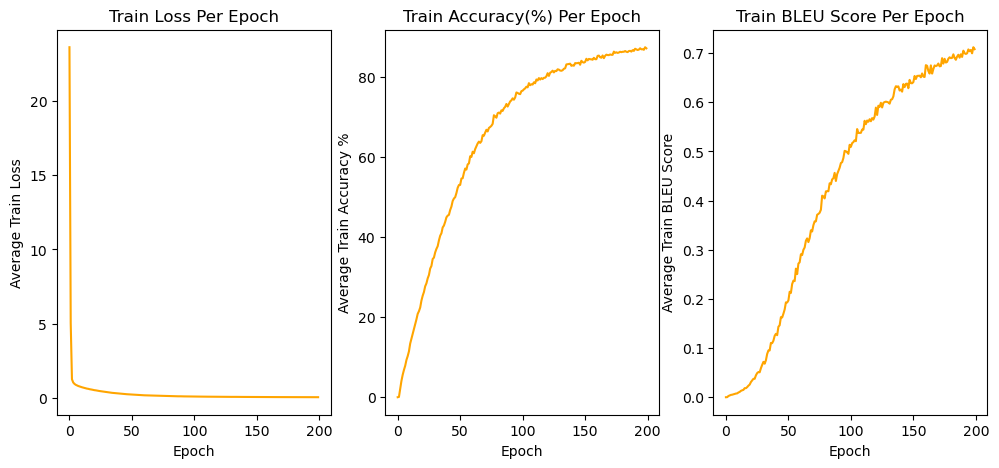

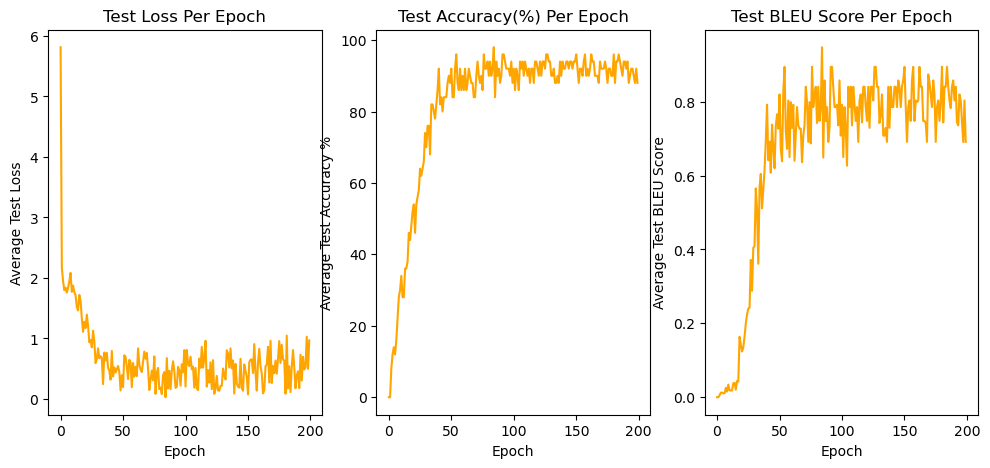

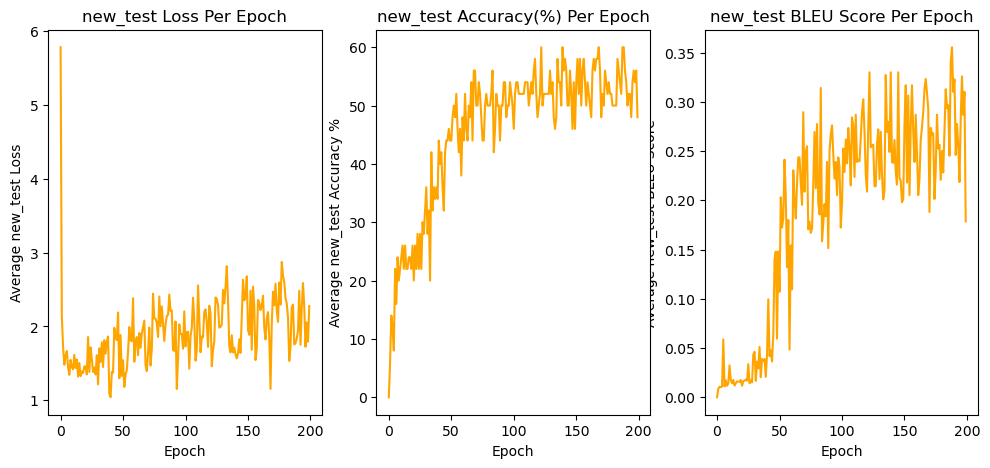

In [110]:
train_model(model, trainloader, testloader, optimizer, num_epochs=200)
